# Classification with logistic regression and support vector machine (SVM)

As we have already discussed, in suppervised learning we have a set of observations (points) with a label assigned to each of them. In particular, in a classification problem such labels are categorical and is our task to train an algorihtm to make future predictions and classify objects according to unobserved features.

In this notebook we present a couple of exmaples to showcase the use of logisitic regression and SVM for classification problems. The intention is to show the capabilities that SVM offers when we have a problem that is not linearly separable. We also show how to use training and validation sets for tunning hyperparameters using grid search. 

## I. Loading needed libraries

As usual, we start by loading the Python libraries we will need

In [1]:
# Typycal Python tools
import sys
import numpy as np
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import os.path

import pylab
from matplotlib import pyplot, cm

# Import sci-kit learn libraries for ML: Linear Regression and SVM
from sklearn import linear_model as linMod
from sklearn import svm, grid_search
# To split into training and test
from sklearn.cross_validation import train_test_split

# To download dataset
import wget

# To show plots inline
%matplotlib inline

## II. Example: Classify students into admitted/not admitted classes

Imagine a group of students taking two exams as part of the process to being admitted into university. You should look at this example as a more elaborate admission process as opposed to the tradition mean of two exams: a committe evaluates the exams and makes a decision without you knowing what the criteria of their decision is. It is then your task to train a model to make future predictions.

### A. Plotting dataset

We begin by plotting the dataset with the corresponding labels. For this purpose we first download the data and write the following function to read them into a pandas dataframe.

In [7]:
!wget -O students_admitted.txt \
https://raw.githubusercontent.com/dataAllAround/data-for-classification/master/students_admitted.txt

--2016-06-27 20:31:25--  https://raw.githubusercontent.com/dataAllAround/data-for-classification/master/students_admitted.txt
Resolving raw.githubusercontent.com... 151.101.56.133
Connecting to raw.githubusercontent.com|151.101.56.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3775 (3.7K) [text/plain]
Saving to: ‘students_admitted.txt’

100%[======================================>] 3,775       --.-K/s   in 0.001s  

2016-06-27 20:31:25 (3.70 MB/s) - ‘students_admitted.txt’ saved [3775/3775]



If the previous cell fails, uncomment the lines below and execute the cell

In [122]:
#file_01 = \
#wget.download("https://raw.githubusercontent.com/dataAllAround/data-for-classification/master/students_admitted.txt")

In [8]:
def PlotDataTXT():
    """
    This function reads data from a txt file and plots them according to the labels (1 or 0) using different
    shapes and colours.
    """
    # Read data to data frame
    df = pd.read_csv("students_admitted.txt")
    # Turn dataframe into matrix
    data = df.values    
    # We separate the given training set into positive (accepted) and negative (not accepted)
    # according to "1" and "0" given in the training set.
    positives  = data[data[:,2] == 1]
    negatives  = data[data[:,2] == 0]
    # We add the X and Y labels...
    pyplot.xlabel("Exam 1 score")
    pyplot.ylabel("Exam 2 score")
    # ... and set the X and Y limit values of the plot.
    pyplot.xlim([25, 105])
    pyplot.ylim([25, 105])
    # We generate the scatter plot according to the separation we just did.
    # Plot negtive examples in yellow circles ...
    pyplot.scatter( negatives[:, 0], negatives[:, 1], c='y', marker='o',
                   s=50, linewidths=1, label="Not admitted" )
    # ... and positve examples in red crosses 
    pyplot.scatter( positives[:, 0], positives[:, 1], c='r', marker='+',
                   s=50, linewidths=2, label="Admitted" )
    # And add legends
    pyplot.legend()

We now simply execute the function to display plot the dataset

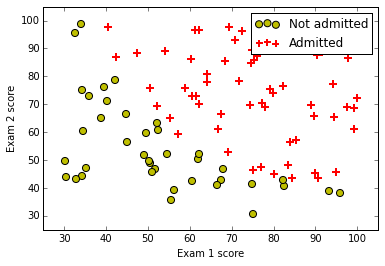

In [124]:
PlotDataTXT()

The plot suggests that we can separate the two classes with a linear boundary. Let's try to do so by means of logisit regression. We first define plotting functions to avoid extensive writing to have plotting capabilities.

### B. Auxiliary plotting functions

The following two functions generate, respectively, plots of the training set and the boundary generated by the model.

In [9]:
def plot(data):
    """
    This function plots training set with selected labels
    """
    # We split data into positive and negative examples according to 
    # labels included in the dataset
    positives = data[data[:, 2] == 1]
    negatives = data[data[:, 2] == 0]
    
    # We add the X and Y labels to the plot
    pyplot.xlabel("Exam 1 score")
    pyplot.ylabel("Exam 2 score")
    
    # We set limits for X and Y axes 
    pyplot.xlim([25, 105])
    pyplot.ylim([25, 105])
    
    # Plot negative examples in yellow circles ...
    pyplot.scatter( negatives[:, 0], negatives[:, 1], c='y', marker='o', s=50,
                   linewidths=1 )
    # ... and positive examples in red crosses
    pyplot.scatter( positives[:, 0], positives[:, 1], c='r', marker='+', s=50,
                   linewidths=2)
    

def PlotBoundary( X, TrainedModel,color ):
    """
    This function plots the boundary decision generated by the trained model
    """
    # Generate evenly separated points for the X and Y axes....
    x1plot = np.linspace( min(X[:, 0]), max(X[:, 0]), 100 )
    x2plot = np.linspace( min(X[:, 1]), max(X[:, 1]), 100 )
    # ... and generate grid based on them
    X1, X2 = np.meshgrid( x1plot, x2plot )
    
    # Set an array of zeroes with the same shape
    vals = np.zeros(X1.shape) 
   
    # 
    aux_shape = X1.shape
        
    for i in range(aux_shape[1]):
        # Concatenate values gotten for the grid
        aux_X = np.c_[ X1[:, i], X2[:, i] ]
        # Generate predicitions based on trained model
        vals[:, i] = TrainedModel.predict( aux_X )
    # Plot!
    pyplot.contour( X1, X2, vals, colors=color )

### C. Logistic regression and its associated boundary decision

We finally generate the logistic regression model and plot its corresponding boundary decision. The following function
reads the data, trains the model, makes predictions and plots the boundary. The only argument of this function is the regularization parameter. Remember that the regulariazation term helps to avoid overfitting. 

In [10]:
def LinRegr_Boundary(Cval,color='blue'):
    """
    This function reads in the reciprocal of the regularization parameter to run
    a logistic regression and plot the boundary decission.
    Note.- Smaller Cval values specify stronger regularization.
    """
    # Read data to dataframe
    df = pd.read_csv("students_admitted.txt")
    # Get values from it to a numpy array
    mat = df.values
    # Split data into features and labels
    X = mat[:,:2] ; y = mat[:,2]
    
    # Instantiate logistic regression
    logreg = linMod.LogisticRegression(C=Cval)
    # Fit model 
    logreg.fit(X, y )
    # Plot training set...
    plot( mat )
    # ... and resulting separating line
    PlotBoundary( X, logreg ,color)
    

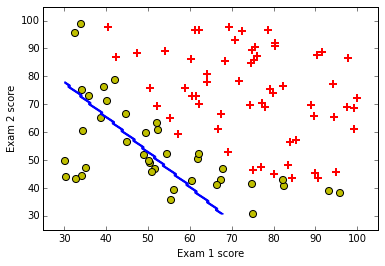

In [11]:
LinRegr_Boundary(0.5)

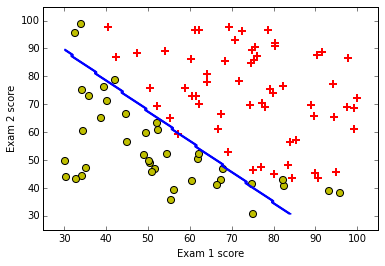

In [147]:
LinRegr_Boundary(2.)

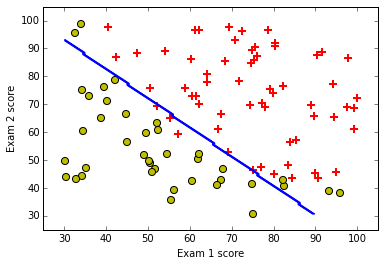

In [77]:
LinRegr_Boundary(1e1)

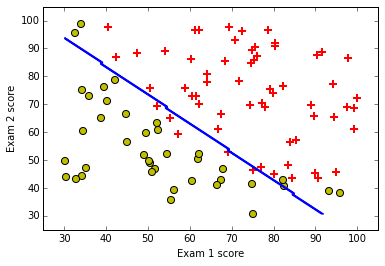

In [78]:
LinRegr_Boundary(1e2)

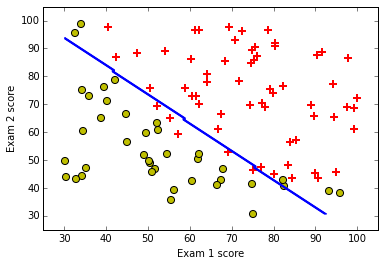

In [79]:
LinRegr_Boundary(1e3)

### D. Support vector machine (SVM) and its associated boundary decision

Let's do classification once again but this time with support vector machine (SVM) with linear kernel. The following function does something similar as the one defined before. Notice that this function requires, in addition to the regularization term, the type of kerned used for the classification process.

In [12]:
def SVM_Boundary_01(Cval,sigmaVal,kernel_type,color='blue'):
    """
    This function reads in the reciprocal of the regularization parameter to run
    a logistic regression and plot the boundary decission.
    Note.- Smaller Cval values specify stronger regularization.
    """
    # Read data to dataframe
    df = pd.read_csv("students_admitted.txt")
    # Get values from it to a numpy array
    mat = df.values
    # Split data into features and labels
    X = mat[:,:2] ; y = mat[:,2]
    
    # gamma is actually inverse of sigma
    svm_ = svm.SVC(C=Cval, kernel=kernel_type, gamma = 1.0 / sigmaVal ) 
    svm_.fit( X, y )


    # Plot training set...
    plot( mat )
    # ... and resulting separating line
    PlotBoundary( X, svm_ ,color)
    

### Linear kernel

We start by trying linear kernel for the classification process

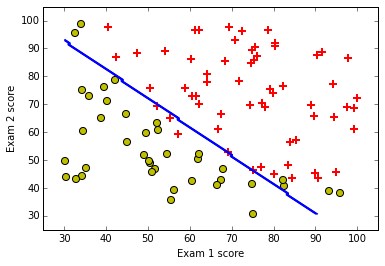

In [81]:
Cval = 10.
sigmaVal = 2000.
kernel_type = 'linear'
SVM_Boundary_01(Cval,sigmaVal,kernel_type)

At a glance, the perfomace of SVM is quite similar the that of logistic regression, as long as we use linear kernel. Let's try to improve the classification by using a non-linear kernel

### Radial basis function kernel

We set the same parameters as before but this time we select a radial basis function to see if we improve the classifier

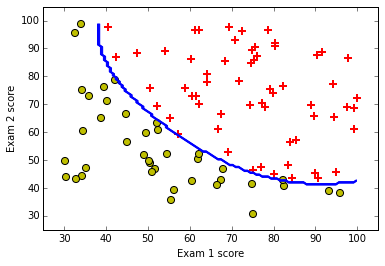

In [82]:
Cval = 10.
sigmaVal = 2000.
kernel_type = 'rbf'
SVM_Boundary_01(Cval,sigmaVal,kernel_type)

We immediatly notice that the non-linearity of the kernel permits to have a better performance in the classifier. Let's plot both classifiers in the same graph to see the difference clearer

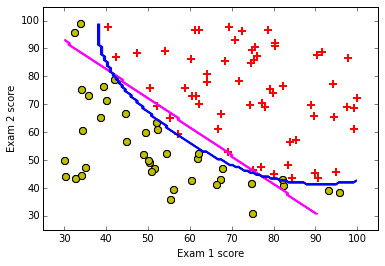

In [83]:
Cval = 10.
sigmaVal = 2000.
SVM_Boundary_01(Cval,sigmaVal,'linear','magenta')
SVM_Boundary_01(Cval,sigmaVal,'rbf')

## III. Example: Classify tumors into malignant/not malignant

We now explore a more challenging situation. The dataset explored in this example contains information regrading tumors detected in patients and we need to classify them into malignant and not malignant. As usual we first download the data

In [13]:
!wget -O tumors_classification.csv \
https://raw.githubusercontent.com/dataAllAround/data-for-classification/master/tumors_classification.csv

--2016-06-27 20:32:58--  https://raw.githubusercontent.com/dataAllAround/data-for-classification/master/tumors_classification.csv
Resolving raw.githubusercontent.com... 151.101.56.133
Connecting to raw.githubusercontent.com|151.101.56.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20425 (20K) [text/plain]
Saving to: ‘tumors_classification.csv’

100%[======================================>] 20,425      --.-K/s   in 0.05s   

2016-06-27 20:32:59 (394 KB/s) - ‘tumors_classification.csv’ saved [20425/20425]



As before, if the previous cell fails, uncomment the lines below and execute the cell

In [125]:
#file_02 = \
#wget.download("https://raw.githubusercontent.com/dataAllAround/data-for-classification/master/tumors_classification.csv")

The next two functions are written to plot the dataset

In [14]:
def plotData( data, addLabel=True ):
    # We separate the given training set into positive (malignant) and negative
    # (not malignant)
    # according to "1" and "0" given in the training set.
    positives  = data[data[:,2] == 1]
    negatives  = data[data[:,2] == 0]
    # We add the X and Y labels...
    pyplot.xlabel("Feature A")
    pyplot.ylabel("Feature B")
    # ... and set the X and Y limit values of the plot.
    pyplot.xlim([0, 1.05])
    pyplot.ylim([0.35, 1])
    
    # We make a distinction whether to include labels
    if addLabel:
        # We generate the scatter plot according to the separation we just did.
        pyplot.scatter( negatives[:, 0], negatives[:, 1], c='y', marker='o', s=50,
                   linewidths=1 , label="Not malignant" )
        pyplot.scatter( positives[:, 0], positives[:, 1], c='r', marker='+', s=50,
                   linewidths=2 , label="Malignant" )
        # And add legends
        pyplot.legend()
    
    else:
         # We generate the scatter plot according to the separation we just did.
        pyplot.scatter( negatives[:, 0], negatives[:, 1], c='y', marker='o', s=50,
                   linewidths=1 )
        pyplot.scatter( positives[:, 0], positives[:, 1], c='r', marker='+', s=50,
                   linewidths=2 )
        
        
def PlotDataFrame():
    df = pd.read_csv("tumors_classification.csv" , index_col=False)
    mat = df.values[:,1:]
    mat[:,2] = mat[:,2].astype(int)
    plotData( mat , addLabel= True )

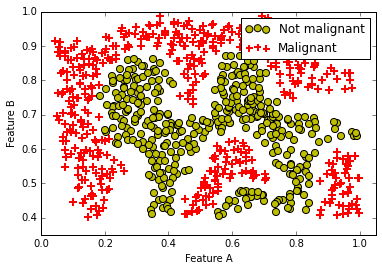

In [15]:
PlotDataFrame()

As we can see from the previous plot it is not possible to classify data with a linear boundary. Let's then apply SVM directly with radial basis function; we write the following function for such goal.

In [16]:
def SVM_Boundary_02(Cval,sigmaVal,kernel_type,color='blue'):
    """
    This function reads in the reciprocal of the regularization parameter to run
    a logistic regression and plot the boundary decission.
    Note.- Smaller Cval values specify stronger regularization.
    """
    
    df = pd.read_csv("tumors_classification.csv" , index_col=False)
    mat = df.values[:,1:]
    mat[:,2] = mat[:,2].astype(int)
    #plotData( mat )
    
    
    # Split data into features and labels
    X = mat[:,:2] ; y = mat[:,2]
    
    # gamma is actually inverse of sigma
    svm_ = svm.SVC(C=Cval, kernel=kernel_type, gamma = 1.0 / sigmaVal ) 
    svm_.fit( X, y )


    # Plot training set...
    plotData( mat , addLabel=False )
    # ... and resulting separating line
    PlotBoundary( X, svm_ ,color)
    

Let's explore the effect of parameters Cval and sigmaVal in the classifier by trying different values for them

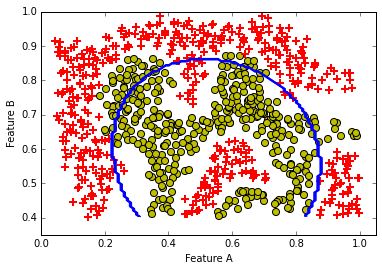

In [17]:
Cval = 1.
sigmaVal = 1.
kernel_type = 'rbf'
SVM_Boundary_02(Cval,sigmaVal,kernel_type)

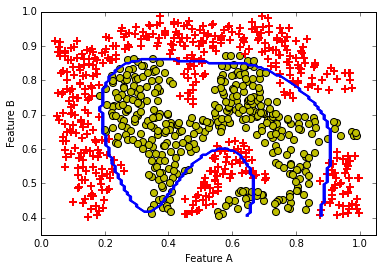

In [18]:
Cval = 1.
sigmaVal = 1e-1
kernel_type = 'rbf'
SVM_Boundary_02(Cval,sigmaVal,kernel_type)

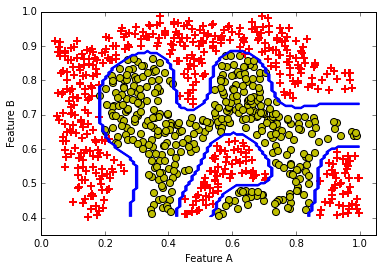

In [131]:
Cval = 1.
sigmaVal = 1e-2
kernel_type = 'rbf'
SVM_Boundary_02(Cval,sigmaVal,kernel_type)

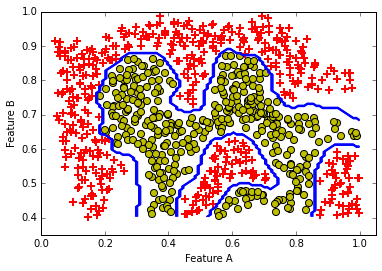

In [132]:
Cval = 1.
sigmaVal = 1e-3
kernel_type = 'rbf'
SVM_Boundary_02(Cval,sigmaVal,kernel_type)

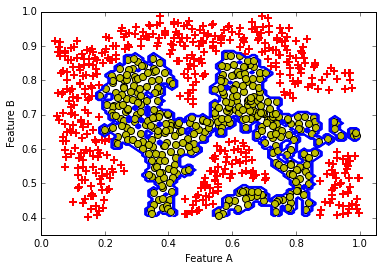

In [133]:
Cval = 1.
sigmaVal = 1e-4
kernel_type = 'rbf'
SVM_Boundary_02(Cval,sigmaVal,kernel_type)

From the previous trials we see that indeed some values of the parameters provide a very good classifier. A natural question to ask is if there is a process by which we can choose "the best" values of such parameters. Notice that so far we have used all the given data available to build the classifier. In what follows we will use subsets of the data given to train our model and choose the best set of parameters. This process is known as **cross-validation**

## IV. Cross-validation and grid search

We now split our data in three subsets: train (60%), validation (20%) and test (20%). We will explain the purpose of each as we show the following cells. We first set a seed to make the split of data as deterministic as possible.

In [19]:
SEED = 2016
random_state = np.random.RandomState(SEED)

We now split our dataset into train, validation and test sets

In [20]:
# We first read data to a data frame
df = pd.read_csv("tumors_classification.csv" , index_col=False)
# Grab the meaningful data and transform it accordingly.
mat = df.values[:,1:]
mat[:,2] = mat[:,2].astype(int)
print "Total number of records " , mat.shape[0]
# We split data into train (60 %) and an auxiliary dataset (40%)...
train_, test_aux = train_test_split(mat, train_size=0.6,random_state=random_state)
# ... and we split this auxiliary dataset into validation (20%) and test sets (20%)
val_, test_ = train_test_split(test_aux, train_size=0.5,random_state=random_state)
print "Records in training set " , train_.shape[0]
print "Records in validation set " , val_.shape[0]
print "Records in test set " , test_.shape[0]


Total number of records  863
Records in training set  517
Records in validation set  173
Records in test set  173


Let's plot first the train set

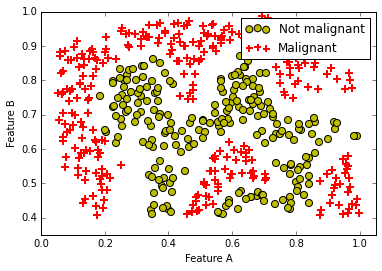

In [21]:
plotData( train_ )

As we can see from the plot, a linear classifier will not be able to make a descent classification. It is time to put SVM to work!

We first prepare the three set of data as needed by scikit learn

In [69]:
# Split data into features and labels. We do this for training, validation and test set
X_train = train_[:,:2] ; y_train = train_[:,2]
X_val = val_[:,:2] ; y_val = val_[:,2]
X_test = test_[:,:2] ; y_test = test_[:,2]

In what follows we will use the training and validation set. The training set will be used with different parameters (values of Cval and sigmaVal) and for each of them we will get the score by using the validation set. The ultimate set of parameters chosen for future predicitons will be the one that gives the best score.

In [91]:
# Empty lists to store scores and parameters...
list_score = []
list_par = []
# We do grid search in Cval ...
for Cval in [1e-2,1e-1,1.,1e1,1e2]:
    # ... and sigmaVal
    for sigmaVal in [1e-2,1e-1,1.,1e1,1e2]:
        # For the pair in turn we instantiate the model...
        svm_ = svm.SVC(C=Cval, kernel='rbf', gamma = 1.0 / sigmaVal ) 
        # ... train it with the training set ...
        svm_.fit( X_train, y_train )
        # ... and evaluate perfomance in the validation set ...
        score_ = svm_.score( X_val,y_val )
        # If desired, print values...
        #print Cval, sigmaVal, score_
        # Add score and parameters to the corresponding lists...
        list_score.append(score_)
        list_par.append([Cval,sigmaVal])

# Store maximum score -- SVM is about maximizing margin 
max_score = max(list_score)

In [92]:
print "Maximum score " ,  max_score

Maximum score  0.988439306358


We will find indices that correspond to the maximum score in list_score and see what parameters they correspond to

In [93]:
selected_parameters = []
indices_ = [i for i, j in enumerate(list_score) if float(j) == max_score]
for k in indices_:
    print list_par[k]
    selected_parameters.append(list_par[k])

[1.0, 0.01]
[10.0, 0.01]
[100.0, 0.01]


We observe that two different values of Cval provide the same score. Let's visualize results in the test set. For this purpouse we first write the function that does the plotting needed.

In [94]:
def SVM_Boundary_Data(Cval,sigmaVal,kernel_type,X,y,color='blue'):
    """
    This function reads in the reciprocal of the regularization parameter to run
    a logistic regression and plot the boundary decission.
    Note.- Smaller Cval values specify stronger regularization.
    """
    
    # gamma is actually inverse of sigma
    svm_ = svm.SVC(C=Cval, kernel=kernel_type, gamma = 1.0 / sigmaVal ) 
    svm_.fit( X, y )

    mat = np.c_[X,y]
    # Plot training set...
    plotData( mat , addLabel=False )
    # ... and resulting separating line
    PlotBoundary( X, svm_,color )
    # Perform classification on X
    #print svm_.predict(X)
    #print y - svm_.predict(X)

Plot, in different colours, boundary for every pair of parameters found 

Parameters Cval and sigmaVal [1.0, 0.01]  in color  blue
Parameters Cval and sigmaVal [10.0, 0.01]  in color  magenta
Parameters Cval and sigmaVal [100.0, 0.01]  in color  green


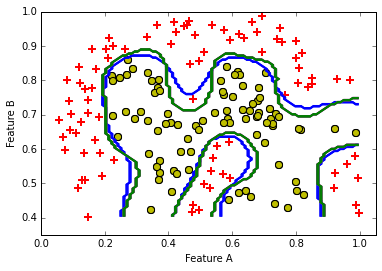

In [118]:
colors_list = ['blue','magenta','green','orange','black']
kernel_type = 'rbf'
for k,par in enumerate(selected_parameters):
    print "Parameters Cval and sigmaVal" ,par, " in color " , colors_list[k]
    Cval,sigmaVal = par
    SVM_Boundary_Data(Cval,sigmaVal,kernel_type,X_test,y_test,color=colors_list[k])
    